In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn.functional as F

from tools.display import extract_minutiae_from_map, draw_minutiae_on_image
from DeepPrint.pretrained import GridSampler

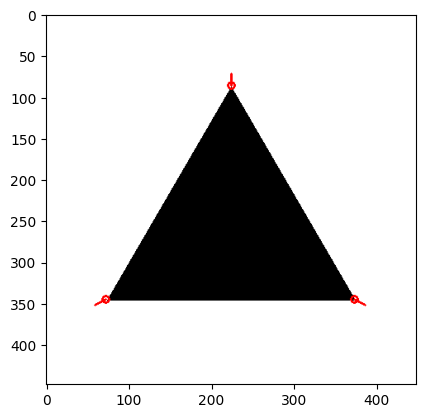

In [2]:
# minutiae = np.load('minutiae.npy')
triangle = np.load('triangle.npy')
triangle = cv2.cvtColor(triangle, cv2.COLOR_BGR2GRAY)
mmap = np.load('mmap.npy')

def plot_image_and_map(img, mmap):
    extracted_minutiae = extract_minutiae_from_map(mmap, 0.5, 15)
    out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    out = draw_minutiae_on_image(out, extracted_minutiae, mmap.shape[:2], triangle.shape[:2])
    plt.imshow(out)

plot_image_and_map(triangle, mmap)

In [3]:
def plot_minutiae_map(H):
    """
    Display a 6-channel minutiae map as a 3x2 grid.
    Args:
        H: np.ndarray of shape (H, W, 6)
    """
    fig, axes = plt.subplots(2, 3, figsize=(6, 8))
    for i in range(6):
        ax = axes[i%2, i//2]
        ax.imshow(H[..., i], cmap='hot')
        ax.set_title(f'Channel {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.00003].


0.00014283923 [(np.int64(160), np.int64(148), np.float32(5.766249)), (np.int64(31), np.int64(148), np.float32(3.658529)), (np.int64(96), np.int64(37), np.float32(1.5707964))]
0.00013762696030257586 [(np.int64(164), np.int64(138), np.float64(6.15614245110949)), (np.int64(42), np.int64(182), np.float64(4.057563892958247)), (np.int64(65), np.int64(55), np.float64(1.9652663226176976))]


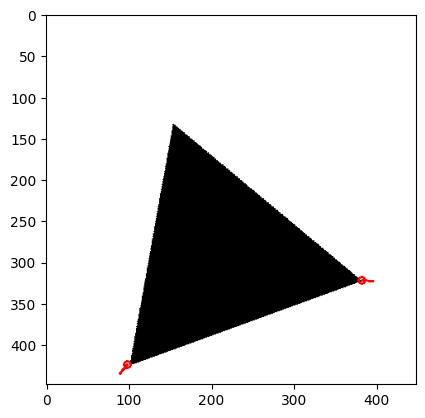

In [4]:
dx = 70
dy = -50
dt = math.pi/9.

def apply_affine_to_img(img_np, dx, dy, dt):
    # Convert to torch tensor and add batch/channel dims
    img_tensor = torch.from_numpy(img_np).float().unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    H, W = img_tensor.shape[-2:]

    tx = dx / W
    ty = dy / H
    theta = dt

    cos_theta = torch.cos(torch.tensor(theta))
    sin_theta = torch.sin(torch.tensor(theta))

    # Affine matrix: [1, 2, 3]
    affine = torch.tensor([[[cos_theta, -sin_theta, tx],
                            [sin_theta,  cos_theta, ty]]], dtype=torch.float)

    grid = F.affine_grid(affine, img_tensor.size(), align_corners=False)
    out = F.grid_sample(img_tensor, grid, align_corners=False, padding_mode='border')
    return out.squeeze().numpy()  # Remove batch/channel dims and return NumPy

def rotate_orientation_channels(mmap_rotated, delta_theta):
    """
    Rotates orientation bins of a 6-channel map by delta_theta radians.
    mmap_rotated: (H, W, 6) — already spatially rotated
    """
    H, W, C = mmap_rotated.shape
    assert C == 6

    # Compute relative circular shift
    bin_shift = -6 * delta_theta / (2 * np.pi)  # negative = CCW rotation

    # Circular interpolation along channel axis
    fft = np.fft.fft(mmap_rotated, axis=2)
    freqs = np.fft.fftfreq(C)[:, None, None]  # shape (6, 1, 1)
    phase = np.exp(2j * np.pi * freqs * bin_shift)
    fft_shifted = fft * phase.T  # transpose for broadcasting
    mmap_rotated_oriented = np.fft.ifft(fft_shifted, axis=2).real

    return mmap_rotated_oriented

def apply_affine_to_map(mmap_np, dx, dy, dt, img_shape=(448, 448)):
    H, W, C = mmap_np.shape
    assert C == 6, "Expected 6 channels in minutiae map"

    # Convert to [1, 6, H, W] tensor
    mmap_tensor = torch.from_numpy(mmap_np).float().permute(2, 0, 1).unsqueeze(0)  # [1, 6, H, W]

    ih, iw = img_shape
    tx = dx / iw
    ty = dy / ih    
    theta = dt

    cos_theta = torch.cos(torch.tensor(theta))
    sin_theta = torch.sin(torch.tensor(theta))

    affine = torch.tensor([[[cos_theta, -sin_theta, tx],
                            [sin_theta,  cos_theta, ty]]], dtype=torch.float)
    # affine = torch.tensor([[[1.0, 0.0, tx],
    #                         [0.0, 1.0, ty]]], dtype=torch.float)

    grid = F.affine_grid(affine, mmap_tensor.size(), align_corners=False)
    transformed = F.grid_sample(mmap_tensor, grid, mode='nearest', align_corners=False)

    # Convert back to [H, W, 6]
    # return transformed.squeeze(0).permute(1, 2, 0).numpy()
    return rotate_orientation_channels(
        transformed.squeeze(0).permute(1, 2, 0).numpy(), dt
    )


rot_img = apply_affine_to_img(triangle, dx, dy, dt)
rot_map = apply_affine_to_map(mmap, dx, dy, dt)

print(mmap.mean(), extract_minutiae_from_map(mmap, 0.5, 15))
print(rot_map.mean(), extract_minutiae_from_map(rot_map, 0.4, 15))

plot_image_and_map(rot_img, rot_map)

In [5]:
from DeepPrint.dataset import DeepPrintDataset

test_dataset = DeepPrintDataset(root='../../../dataset-fingerprints/', split='train')

263 images for 6 classes found for train split


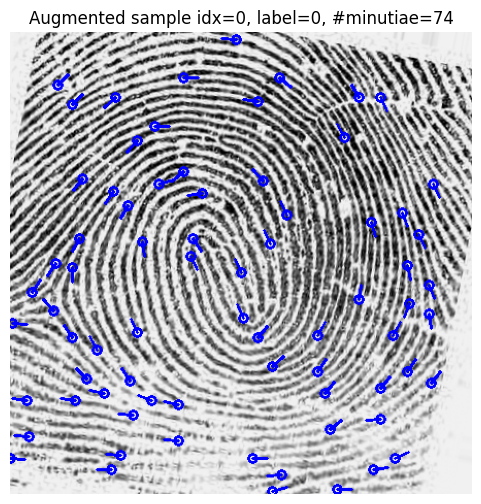

In [6]:
import matplotlib.pyplot as plt
from DeepPrint.display import extract_minutiae_from_map, draw_minutiae_on_image
import cv2

idx = 0
img, label, H = test_dataset.__getitem__(idx)

img_np = (img.squeeze().numpy() * 255).astype(np.uint8)
map_np = H.permute(1, 2, 0).numpy()
h_img, w_img = img_np.shape
h_map, w_map = H.shape[1], H.shape[2]

# Extract minutiae from map
minutiae = extract_minutiae_from_map(map_np, 0.5, 5)

# Draw on image
img_with_minutiae = draw_minutiae_on_image(img_np, minutiae, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_with_minutiae, cv2.COLOR_BGR2RGB))
plt.title(f"Augmented sample idx={idx}, label={label}, #minutiae={len(minutiae)}")
plt.axis('off')
plt.show()

0it [00:06, ?it/s]
C:\Users\abis\AppData\Local\Temp\ipykernel_16780\4139310957.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(dt, device=device)


tensor([-0.0330], grad_fn=<SelectBackward0>)


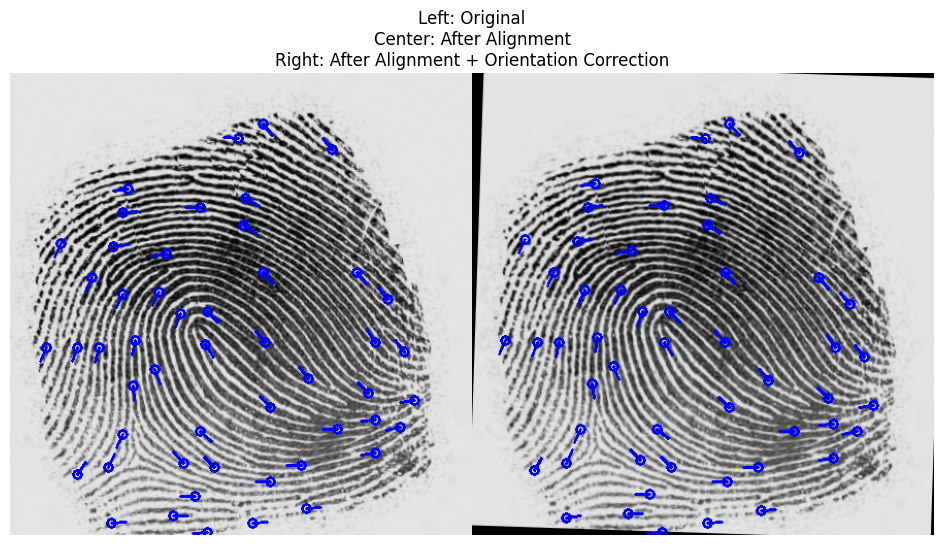

In [13]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from DeepPrint.pretrained import DeepPrintNet

def rotate_orientation_channels_torch(mmap_tensor, delta_theta):
    """
    Rotates the orientation channels of a 6-channel minutiae map tensor (circular shift).

    Args:
        mmap_tensor: torch.Tensor of shape [1, 6, H, W] (or [B, 6, H, W])
        delta_theta: scalar float in radians (clockwise positive)

    Returns:
        Rotated tensor, same shape [B, 6, H, W]
    """
    B, C, H, W = mmap_tensor.shape
    assert C == 6, "Expected 6 orientation bins"

    # Compute fractional shift
    shift = -6 * delta_theta / (2 * torch.pi)  # counter-clockwise

    # DFT over orientation dimension (dim=1)
    fmap = torch.fft.fft(mmap_tensor, dim=1)

    # Frequency indices (shape [C], from 0 to C-1)
    freqs = torch.fft.fftfreq(C, device=mmap_tensor.device).view(1, C, 1, 1)

    # Complex exponential phase shift
    phase = torch.exp(-2j * torch.pi * freqs * shift)

    # Apply phase shift (broadcast over B, H, W)
    fmap_shifted = fmap * phase

    # Inverse FFT
    rotated = torch.fft.ifft(fmap_shifted, dim=1).real

    return rotated

def apply_affine_to_map_tensor(mmap_tensor, dx, dy, dt, img_shape=(448, 448)):
    """
    Applies affine transform (translation + rotation) to a 6-channel minutiae map tensor.

    Args:
        mmap_tensor: torch.Tensor of shape [1, 6, H, W]
        dx, dy: translation in image pixels (same scale as img_shape)
        dt: rotation in radians
        img_shape: shape of source image that the map aligns to (used to normalize dx, dy)

    Returns:
        Transformed map tensor, same shape [1, 6, H, W]
    """
    assert mmap_tensor.dim() == 4 and mmap_tensor.size(1) == 6, "Expected shape [1, 6, H, W]"
    device = mmap_tensor.device
    _, _, H, W = mmap_tensor.shape
    ih, iw = img_shape

    tx = dx / iw
    ty = dy / ih

    theta = torch.tensor(dt, device=device)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    affine = torch.tensor([[[cos_theta, -sin_theta, tx],
                            [sin_theta,  cos_theta, ty]]], dtype=torch.float, device=device)

    grid = F.affine_grid(affine, mmap_tensor.size(), align_corners=False)
    transformed = F.grid_sample(mmap_tensor, grid, mode='nearest', align_corners=False)

    # Rotate orientation channels
    rotated = rotate_orientation_channels_torch(transformed, dt)
    #rotated_tensor = rotated.permute(2, 0, 1).unsqueeze(0).to(device)
    return rotated

device = 'cpu'
model = DeepPrintNet(100).to(device).eval()

train_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
tqdm_bar = tqdm(enumerate(train_loader))
for batch_idx, (imgs, labels, maps) in tqdm_bar:
    imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
    outputs = model(imgs)
    break

# ---- Get predicted alignment ----
B, C, H, W = maps.shape
tx = outputs['alignment'][:, 0] / W
ty = outputs['alignment'][:, 1] / H
theta = outputs['alignment'][:, 2]
print(theta)

rot_map = apply_affine_to_map_tensor(maps, tx, ty, theta)

# ---- Get input and aligned images (first sample) ----
original_img = imgs[0].detach().cpu().squeeze().numpy()
aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()

original_img_uint8 = (original_img * 255).astype(np.uint8)
aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

h_img, w_img = aligned_img_uint8.shape
h_map, w_map = H, W

# ---- Extract minutiae ----
minutiae_original = extract_minutiae_from_map(maps[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)
minutiae_shifted = extract_minutiae_from_map(rot_map[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)

# ---- Draw overlays ----
img_ori_overlay = draw_minutiae_on_image(original_img_uint8, minutiae_original, map_shape=(h_map, w_map), img_shape=(h_img, w_img))
img_shifted_overlay = draw_minutiae_on_image(aligned_img_uint8, minutiae_shifted, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

# ---- Concatenate and show ----
concat = cv2.hconcat([
    cv2.cvtColor(img_ori_overlay, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(img_shifted_overlay, cv2.COLOR_BGR2RGB)
])

plt.figure(figsize=(12, 6))
plt.imshow(concat)
plt.title("Left: Original\nCenter: After Alignment\nRight: After Alignment + Orientation Correction")
plt.axis('off')
plt.show()